# Урок 6

1. Постановка задачи.
2. Препроцессим данные.
3. Токенизуем текст на слова.
4. Возьмем предобученный Word2Vec, получим из него эмбеддинги слов.
5. Паддинг в текстах: что это и зачем нужно.
6. Соберем Dataset и DataLoader из текстов.
7. Обучаем модель регрессии над текстом.

## Постановка задачи


Требуется по заголовку объявления и его тексту предсказать, какую зарплату за это объявление предложат.

Датасет возьмем из соревнования ["Job Salary Prediction"](https://www.kaggle.com/competitions/job-salary-prediction/data).

В качестве метрики качества будем рассматривать MAE, подсчитанную на логарифме таргета.

В качестве модели возьмем TextCNN, оптимизатор Adam.

## Смотрим на данные, препроцессим их

In [1]:
import pandas as pd

# Данные скачать отсюда https://www.kaggle.com/competitions/job-salary-prediction/data
# Нас интересует Train_rev1.csv
data = pd.read_csv("Train_rev1.csv", index_col=None)
print(data.shape)
data.head(2)

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [2]:
from sklearn.model_selection import train_test_split

seed = 0
data_train_val, data_test = train_test_split(data, test_size=0.2, random_state=seed)
data, data_val = train_test_split(data_train_val, test_size=0.2, random_state=seed)

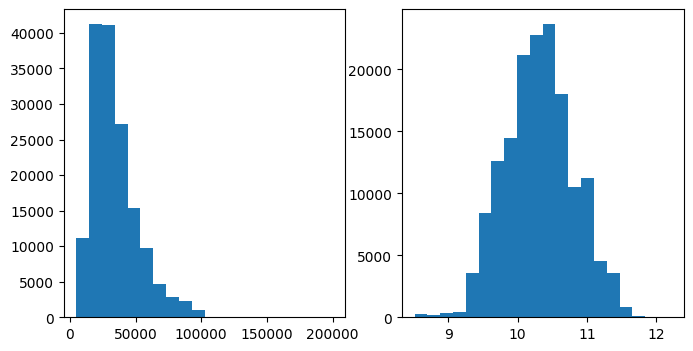

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20);

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"


data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
167173,71305312,Quantitative Research Associate Excellent Pac...,Graduate Quantitative Research Associate – Lea...,Hertfordshire South East,UK,NaN,permanent,IT Retail People Ltd,IT Jobs,"Up to 22,000 per annum Bonus, Training & Lunch!",22000,cwjobs.co.uk,9.998843
12580,66557843,M&A Manager,The role will include: Managing tax implicati...,London,London,NaN,permanent,NaN,Accounting & Finance Jobs,60000 - 70000,65000,michaelpage.co.uk,11.082158
135143,70260113,Children's Palliative Care Nurses,Children's Palliative Care Nurses **** to ***...,"Mid Kent, South East",UK,NaN,NaN,Sterling Cross,Healthcare & Nursing Jobs,"23,677.00 - 32,208.00 per annum",27942,rcnbulletinjobs.co.uk,10.237922


## Токенизация

Напомним, что токен - это некая единица текста. Токеном может быть слово, буква, несколько букв.

Воспользуемся пакетом `nltk` для разбиения текста на токены. В качестве токенов будем использовать отдельные слова.

In [5]:
import nltk
import tqdm

data.fillna({"Title": "NaN"}, inplace=True)
tokenizer = nltk.tokenize.WordPunctTokenizer()
for col in ("FullDescription", "Title"):
    tmp = [" ".join(tokenizer.tokenize(x)).lower() for x in tqdm.tqdm(data[col])]
    data[col] = tmp

100%|██████████| 156651/156651 [00:00<00:00, 826721.55it/s]


In [6]:
data['FullDescription'].map(len).max()

14645

In [7]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer

# Запроцессим категориальные фичи:
# - заполним пропуски
# - возьмем топ 2к компаний;
# - сделаем OHE над колонками;
data[categorical_columns] = data[categorical_columns].fillna("NaN")
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

## Эмбеддинги

Эмбеддинг - это векторное представление токена.
В этом демо для получения из токена его эмбеддинг будем использовать `word2vec`, предобученный на `Google News`.

In [8]:
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")
print(type(wv))
print(wv.get_vector("map").shape)
print(wv.has_index_for('map'))

<class 'gensim.models.keyedvectors.KeyedVectors'>
(300,)
True


In [9]:
take_first_n = 1_000

# Весь датасет не влезет в RAM, будем бить на батчи
# Возьмите subset = data - и увидите, что не помещается
subset = data.iloc[:100].copy()
for col in ("FullDescription", "Title"):
    new_data = [
        np.stack(
            [
                wv.get_vector(x)
                for x in tokens.split()[:take_first_n]
                if wv.has_index_for(x)
            ]
        )
        for tokens in tqdm.tqdm(subset[col])
    ]
    subset[f"emb_{col}"] = new_data

100%|██████████| 100/100 [00:00<00:00, 47153.50it/s]


In [10]:
# тексты разной длины
subset["emb_FullDescription"].map(lambda x: x.shape)

104939    (108, 300)
45543     (112, 300)
164172    (232, 300)
20726     (442, 300)
194925     (93, 300)
             ...    
174632    (289, 300)
175751    (155, 300)
183638    (271, 300)
208091    (171, 300)
198073    (300, 300)
Name: emb_FullDescription, Length: 100, dtype: object

## Паддинг
Помним, что когда объединяем в батч, все размерности должны быть одинаковы.

Чтобы суметь собрать тексты разной длины в один батч, приведем все предложения к одной длине.
Для этого добавим некоторый специальный символ - например, `<PAD>`.

В `word2vec-google-news-300` нет явного символа паддинга (обычно это `<PAD>`),
но мы можем взять любой другой символ, который точно не встречается в текстах.

In [11]:
# Возьмем </s> - только проверим, что его нет в наших текстах
wv.index_to_key[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [12]:
# Оба assert проходит - значит, </s> можно использовать как токен для паддинга
assert 0 == data["Title"].map(lambda tokens: "</s>" in tokens).sum()
assert 0 == data["FullDescription"].map(lambda tokens: "</s>" in tokens).sum()

In [13]:
# Эту функцию дальше не будем использовать, но она демонстрирует идею паддинга
def pad_sequence(series: pd.Series, pad_length: int, pad_token: str = "</s>"):
    return series.map(
        lambda tokens: " ".join(
            tokens.split() + [pad_token] * max(0, pad_length - len(tokens.split()))
        )
    )


pad_sequence(subset["Title"], 15).head(15)

104939    nursery manager </s> </s> </s> </s> </s> </s> ...
45543     retail advisor – gateshead cameron walk ( part...
164172    finance manager london </s> </s> </s> </s> </s...
20726     weekend showroom host , high wycombe , motor t...
194925    registered nurses ( rgn ' s rmn ' s & rnld ' s...
222927    field sales executive portable appliance / ele...
206627    real estate partner </s> </s> </s> </s> </s> <...
127166    clinical advisor patient monitoring </s> </s> ...
123545    retail sales consultant </s> </s> </s> </s> </...
42842     senior systems analyst </s> </s> </s> </s> </s...
60993     digital graphic design manager asda </s> </s> ...
32378     materials planner / stock controller / buyer <...
122579    cnc machine operator </s> </s> </s> </s> </s> ...
150341    hr business partner cipd charitable organisati...
80759     evening cleaner hilton birmingham metropole </...
Name: Title, dtype: object

То, что видим выше - это типичный результат после применения паддинга.

In [14]:
from collections.abc import Collection
from gensim.models import KeyedVectors


def pad_or_trim_to_length(
    pad_length: int, vectors: list[np.ndarray], pad_vector: np.ndarray
):
    assert pad_vector.ndim == 1
    # допаддим слева, а если превысили - обрежем с конца
    vectors = vectors[:pad_length] + [pad_vector] * max(0, pad_length - len(vectors))
    return np.stack(vectors)


def seq_to_emb(
    sentences: Collection[str], wv: KeyedVectors, pad_length: int, pad_token: str = "</s>"
):
    rv = []
    for sentence in sentences:
        sentence_embeddings = []
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_length(
            pad_length, sentence_embeddings, wv.get_vector(pad_token)
        )
        rv.append(np.stack(sentence_embeddings))
    return np.stack(rv)

In [15]:
seq_to_emb(subset["Title"], wv, 50).shape

(100, 50, 300)

In [16]:
# Какую длину в паддинге выбрать? Подсчитаем по датасету
print(
    "Максимальное количество токенов в колонке 'Title':",
    data["Title"].map(lambda x: x.split()).map(len).max(),
)
print(
    "Максимальное количество токенов в колонке 'FullDescription':",
    data["FullDescription"].map(lambda x: x.split()).map(len).max(),
)
# Возьмем 40 и 2317 - почему бы и нет?

Максимальное количество токенов в колонке 'Title': 40
Максимальное количество токенов в колонке 'FullDescription': 2317


## Собираем Dataset и DataLoader

In [17]:
# Соберем все в датасет, который запроцессит данные, токенизует и превратит в эмбеддинги
from torch.utils.data import Dataset
import torch


class CvTextDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        pad_title_len: int,
        pad_desc_len: int,
        wv: KeyedVectors,
        categorical_vectorizer: DictVectorizer,
    ):
        # Далее будут те коды препроцессинга, что писали ранее
        self.target_column = "Log1pSalary"
        data[self.target_column] = np.log1p(data["SalaryNormalized"]).astype("float32")

        # Кат. фичи: заполнить пропуски, взять топ популярных компаний и OHE
        data[categorical_columns] = data[categorical_columns].fillna("NaN")
        top_companies, _ = zip(*Counter(data["Company"]).most_common(2000))
        recognized_companies = set(top_companies)
        data["Company"] = data["Company"].apply(
            lambda comp: comp if comp in recognized_companies else "Other"
        )
        self.categorical_vectorizer = categorical_vectorizer

        # Текстовые фичи: токенизация
        self.text_columns = ["Title", "FullDescription"]
        data.fillna({k: "NaN" for k in self.text_columns}, inplace=True)
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        for col in self.text_columns:
            tmp = [
                " ".join(tokenizer.tokenize(x)).lower() for x in tqdm.tqdm(data[col])
            ]
            data[col] = tmp
        self.pad_len_for_column = {
            "Title": pad_title_len,
            "FullDescription": pad_desc_len,
        }

        self.wv = wv
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor, float]:
        one_row = self.data.iloc[index]
        target = one_row[self.target_column]
        rv = {}
        # Сначала две текстовые колонки, потом категориальные
        for one_feature in self.text_columns:
            rv[one_feature] = torch.from_numpy(
                seq_to_emb(
                    [one_row[one_feature]],
                    wv=self.wv,
                    pad_length=self.pad_len_for_column[one_feature],
                )
            ).squeeze(0)
        for one_feature in categorical_columns:
            rv[one_feature] = torch.from_numpy(
                self.categorical_vectorizer.transform(
                    {one_feature: one_row[one_feature]}
                )
            ).squeeze(0)
        rv[self.target_column] = target
        return rv

In [18]:
train_dataset = CvTextDataset(
    data,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
val_dataset = CvTextDataset(
    data_val,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
test_dataset = CvTextDataset(
    data_test,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
# print(len(train_dataset))
print(len(test_dataset))
x = test_dataset[0]
print(type(x["Title"]), type(x["FullDescription"]))
print(
    x["Title"].shape,
    x["FullDescription"].shape,
    x["Company"].shape,
    x["Log1pSalary"].shape,
)

100%|██████████| 48954/48954 [00:02<00:00, 23859.05it/s]

48954
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([40, 300]) torch.Size([2317, 300]) torch.Size([3403]) ()


In [19]:
x.keys()

dict_keys(['Title', 'FullDescription', 'Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'Log1pSalary'])

In [20]:
import os
import random


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)


def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


enable_determinism()
fix_seeds(0)

In [21]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=24,
    pin_memory=False,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)
[x.shape for x in next(iter(test_loader)).values()]

[torch.Size([64, 40, 300]),
 torch.Size([64, 2317, 300]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64, 3403]),
 torch.Size([64])]

## TextCNN

Одна из самых ранних моделей в мире NLP. [Статья](https://arxiv.org/abs/1408.5882).
Архитектура следующая:

<center><img src="./textcnn.png"></center>

6 ядер, по 2 ядра размерами 2, 3 и 4 соответственно. Затем MaxPool.
Все выходы сшиваются в один вектор - и передаются в FC слой.

Мы сделаем то же самое, но добавим еще один ингредиент - категориальные фичи.
Их прогоним через FC, соединим с вектором из других выходов - и точно так же подадим в финальный FC слой.

<center><img src="./final-arch.png"></center>

In [22]:
import torch.nn as nn

filter_sizes = [2, 3, 4]
num_filters = 2


class TextCnn(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 300
        self.text_filters = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(emb_size, num_filters, kernel_size=filter_sizes[i]),
                    nn.ReLU(),
                )
                for i in range(len(filter_sizes))
            ]
        )
        self.cat_network = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(len(categorical_vectorizer.vocabulary_), num_filters),
                    nn.ReLU(),
                )
                for _ in range(len(categorical_columns))
            ]
        )
        self.fc = nn.Linear(
            num_filters
            * (len(filter_sizes) * len(text_columns) + len(categorical_columns)),
            1,
        )

    def forward(self, data: dict[str, torch.Tensor]):
        to_fc = []
        for key in text_columns:
            x = data[key]
            rv = []
            for f in self.text_filters:
                # Свертка - выдаст [(bs, 2, n - 1), (bs, 2, n - 2), (bs, 2, n - 3)]
                result = f(x.permute((0, 2, 1)))
                # MaxPooling вдоль предложения - даст [(bs, 2), (bs, 2), (bs, 2)]
                result = torch.max(result, dim=2)[0]
                rv.append(result)
            x = torch.concat(rv, dim=1)
            to_fc.append(x)

        for i, key in enumerate(categorical_columns):
            x = data[key]
            x = self.cat_network[i](x)
            to_fc.append(x)

        x = torch.hstack(to_fc)
        x = self.fc(x).squeeze(1)
        return x

In [23]:
model = TextCnn()
model(next(iter(test_loader))).shape

torch.Size([64])

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
import torch.nn.functional as F
import wandb
from torch.optim import Adam

loss_fn = F.l1_loss


@torch.no_grad
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    for x in loader:
        x = {k: v.to(device) for k, v in x.items()}
        pred = model(x)
        loss = loss + loss_fn(pred, x[TARGET_COLUMN])
    model.train()
    return (loss / len(loader)).item()


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    wandb.watch(model, criterion=loss_fn, log="parameters", log_freq=100)
    for _ in range(n_epochs):
        for x in tqdm.tqdm(train_loader):
            x = {k: v.to(device) for k, v in x.items()}
            pred = model(x)
            loss = loss_fn(pred, x[TARGET_COLUMN])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"loss": loss.item()})
        wandb.log({"val_loss": loss_on_dataset(model, val_loader, device)})
    return optimizer


wandb.init(project="start-dl--lesson-6")
train_loop(model, train_loader, val_loader, device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alekseik1. Use `wandb login --relogin` to force relogin


/home/aleksei/.cache/pypoetry/virtualenvs/start-dl-fEQaQ9Q8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2448/2448 [02:16<00:00, 17.97it/s]


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [26]:
# Подсчитаем, насколько модель ошибается на test датасете
model.to(device).eval()
losses = []
for x in tqdm.tqdm(test_loader):
    x = {k: v.to(device) for k, v in x.items()}
    with torch.no_grad():
        pred = model(x)
    for i in range(pred.shape[0]):
        losses.append((pred - x[TARGET_COLUMN])[i].item())

100%|██████████| 765/765 [00:38<00:00, 19.78it/s]


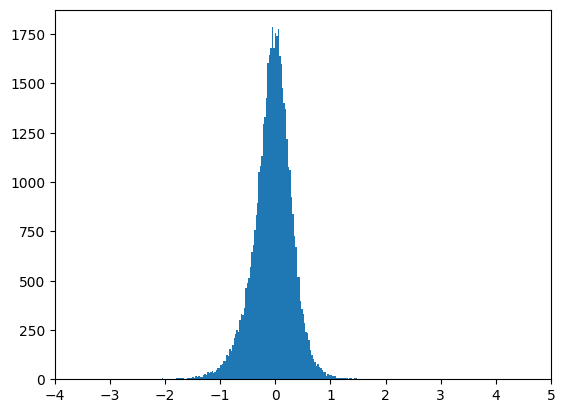

In [27]:
plt.hist(losses, bins=200)
plt.xlim((-4, 5));

In [28]:
np.mean(losses)

-0.04822667488481219

Что дальше?

1. Попробовать другие эмбеддинги. Например, [fasttext](https://radimrehurek.com/gensim/models/fasttext.html).
2. Добавить больше фильтров. У нас их на все ядра по 2 штуки - как в оригинальной статье. Но можно больше.

Кстати, попробуйте поменять оптимизатор с Adam на SGD и посмотрите, насколько хорошо будет идти процесс обучения.

## Резюме
1. Узнали, как разбить текст на токены.
2. Узнали, как преобразовать токены в векторы (эмбеддинги) с помощью библиотеки `gensim`.
3. Научились строить модель регрессии поверх эмбеддингов (TextCNN).
4. Обучили модель, получили неплохое качество.